# Let's figure out how to select globular clusters

I'll begin by trying 47 Tuc, or NGC0104. According to [Wikipedia](https://en.wikipedia.org/wiki/47_Tucanae), it's located 4 kpc away and has a mass of $7\times 10^5~M_\odot$. It is located at right ascension 00h 24m 05.67s and declination –72d 04m 52.6s.

In [1]:
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline 

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
data_dir = os.path.abspath(os.path.join(root_dir, '..', 'data'))

In [2]:
radec_47tuc = SkyCoord(['00h 24m 05.67s -72d 04m 52.6s'])
radec_47tuc.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(305.8948115, -44.88933794)]>

## Download from Gaia archives

ADQL Query:

```SQL
SELECT TOP 1000000 
    source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,
    pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,bp_g,g_rp,
    radial_velocity,radial_velocity_error,phot_variable_flag,
    l,b,teff_val,a_g_val 
FROM gaiadr2.gaia_source  
WHERE
    CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),
             CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(6.0223292,-72.0814444,-18.7000,3.4400,.0000,0,2000,2015.5)),
                           COORD2(EPOCH_PROP_POS(6.0223292,-72.0814444,-18.7000,3.4400,.0000,0,2000,2015.5)),
                    0.6666666666666666))=1    
    AND  (parallax_over_error>=10)
```

These have now been saved in `/Users/jfwu/projects/gaia-dr2/data/47-Tuc.csv`.

In [3]:
df = pd.read_csv(os.path.join(data_dir, '47-Tuc.csv'))
df.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,phot_variable_flag,l,b,teff_val,a_g_val
0,4689543501942616960,5.643280,0.150027,-72.538721,0.121674,1.591467,0.158534,20.419773,0.313727,4.693090,...,2.390957,1.228901,1.162056,NaN,NaN,NOT_AVAILABLE,305.956961,-44.419596,NaN,NaN
1,4689544502681237632,5.576432,0.018723,-72.520857,0.015306,0.997813,0.017269,17.807881,0.037380,-1.530716,...,0.852867,0.344833,0.508034,NaN,NaN,NOT_AVAILABLE,305.988647,-44.434082,5757.6665,0.5515
2,4689544464018993408,5.492012,0.556716,-72.514899,0.432230,6.941706,0.572667,58.819445,1.294009,3.188057,...,2.318495,0.744360,1.574135,NaN,NaN,NOT_AVAILABLE,306.025038,-44.435934,NaN,NaN
3,4689529453115818624,5.398870,0.055554,-72.706408,0.047581,3.471316,0.057096,0.559745,0.107001,15.653579,...,2.191312,1.130794,1.060517,NaN,NaN,NOT_AVAILABLE,306.020459,-44.242441,3658.0000,0.1780
4,4689529659274248704,5.405954,0.021534,-72.701799,0.017748,0.790745,0.021552,-3.914828,0.039696,6.436861,...,0.825540,0.334913,0.490626,NaN,NaN,NOT_AVAILABLE,306.018595,-44.247329,5815.7500,0.3040


In [4]:
df.columns

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'radial_velocity',
       'radial_velocity_error', 'phot_variable_flag', 'l', 'b', 'teff_val',
       'a_g_val'],
      dtype='object')

#### Sanity check: the $l$ and $b$ values appear to be consistent with what we found above.

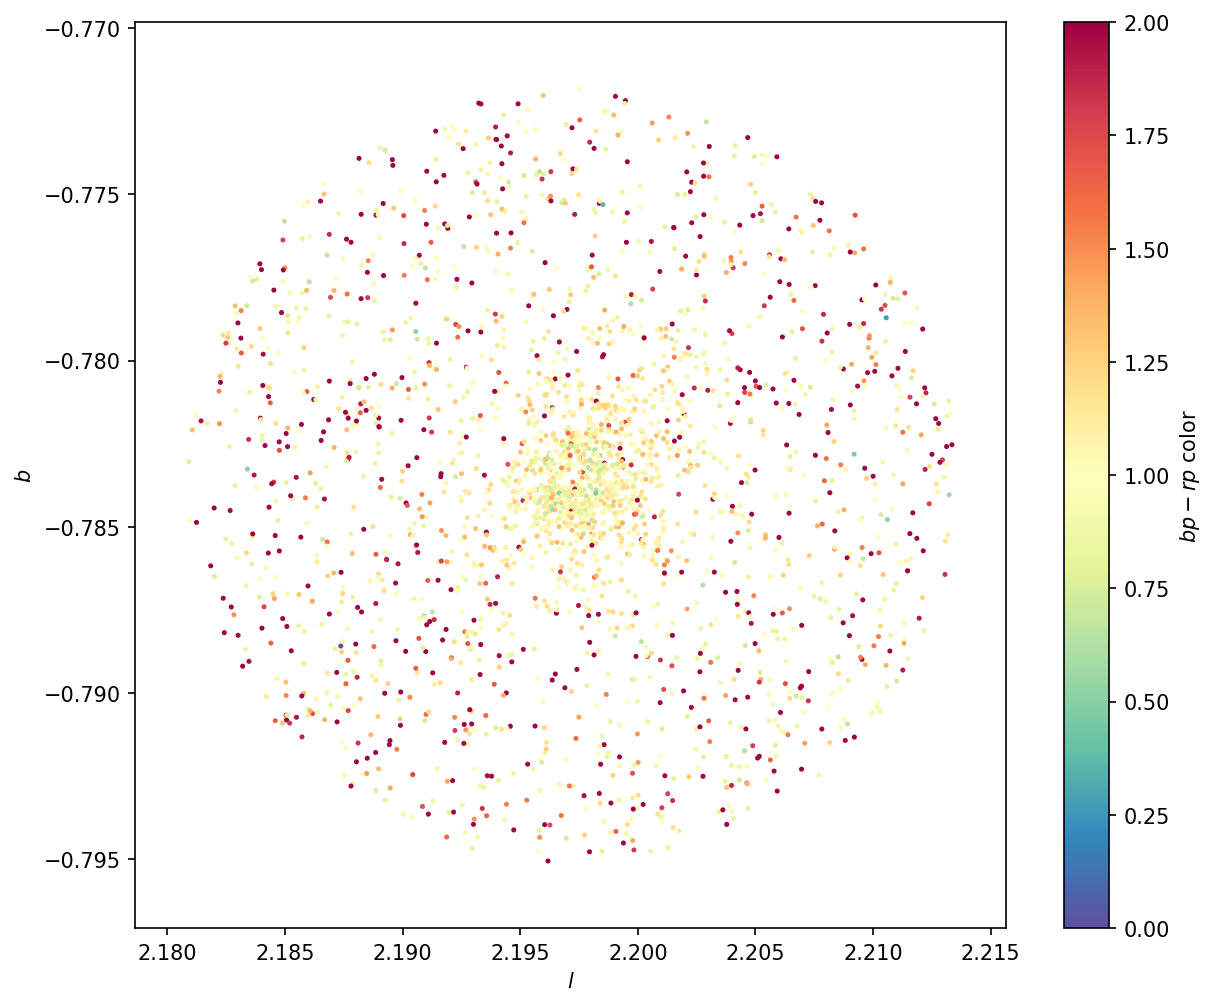

In [5]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)
im = ax.scatter(np.deg2rad(df.l - 180), np.deg2rad(df.b), c=df.bp_rp, s=2., cmap=plt.cm.Spectral_r, vmin=0, vmax=2)
cbar = fig.colorbar(im)
cbar.set_label('$bp - rp$ color')

ax.set_xlabel('$l$')
ax.set_ylabel('$b$')
ax.set_aspect(1. / np.cos(np.deg2rad(df.b.mean())))
plt.show()

#### Okay, so why is the globular cluster *bluer* than its surroundings?

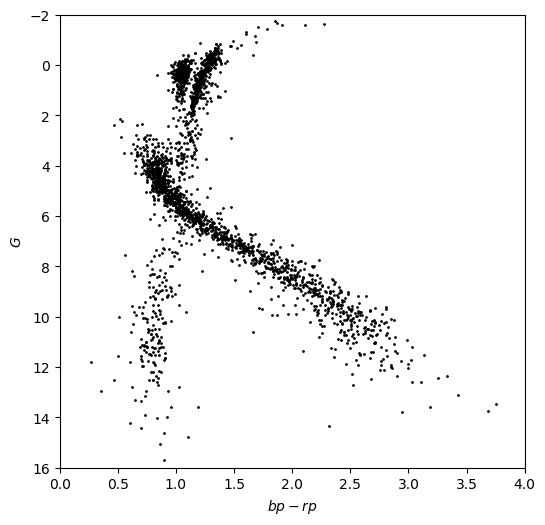

In [21]:
plt.figure(figsize=(6, 6), dpi=100)

DM = 5 * (np.log10(1000 / df.parallax) - 1)

plt.scatter(df.bp_rp, df.phot_g_mean_mag - DM, c='k', s=1.)

plt.xlim(0, 4)
plt.ylim(16, -2)
plt.ylabel('$G$')
plt.xlabel('$bp - rp$');

### Time for proper motions 

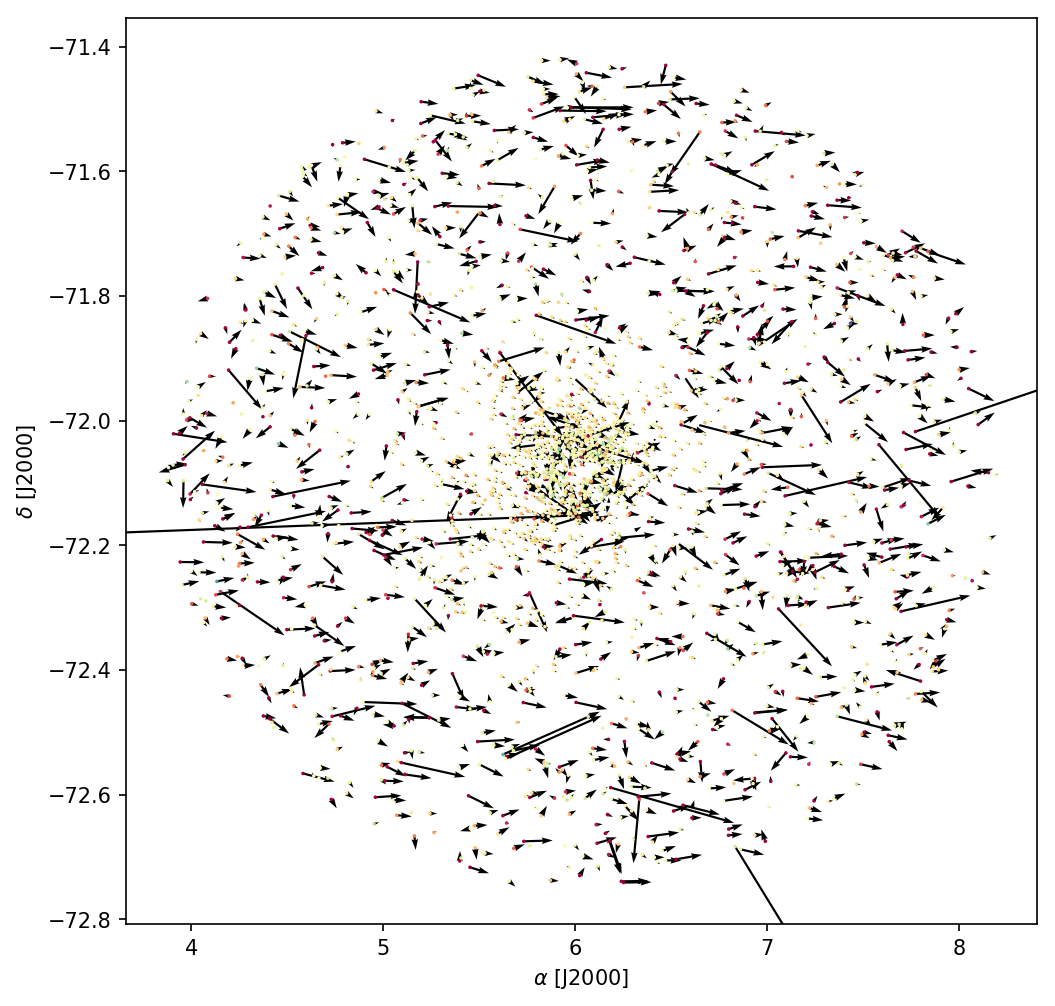

In [67]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)


q = ax.quiver(df.ra, df.dec, df.pmra, df.pmdec)
ax.scatter(df.ra, df.dec, c=df.bp_rp, s=0.5, cmap=plt.cm.Spectral_r, vmin=0, vmax=2)

ax.set_xlabel(r'$\alpha$ [J2000]')
ax.set_ylabel(r'$\delta$ [J2000]')
ax.set_aspect(1. / np.cos(np.deg2rad(df.dec.mean())))
plt.show()

#### Two things to remember: 
1. Some of these proper motions may be noisy, so we should implement a cut
2. It would be a good idea to zoom in here
3. Parallax would make a good cut criterion

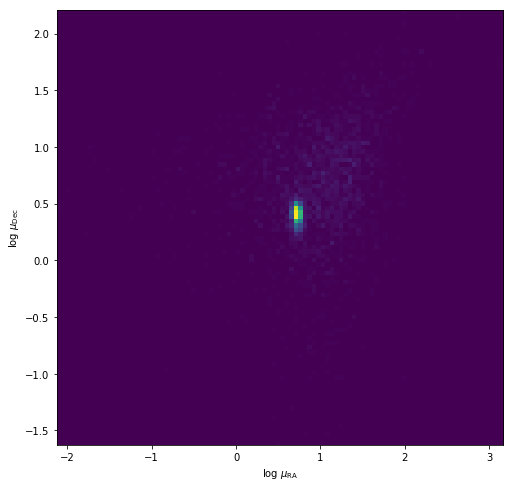

In [107]:
plt.figure(figsize=(8, 8))
plt.hist2d(x=np.log10(np.abs(df.pmra)), y=np.log10(np.abs(df.pmdec)), bins=100);
plt.xlabel(r'log $\mu_{\rm RA}$')
plt.ylabel(r'log $\mu_{\rm Dec}$');

#plt.xlim(0.5, 1)
#plt.ylim(0.25, 0.75)

So it looks like proper motions $\mu$ fall into a particular range. I can use a clustering routine (or Gaussian mixture model) to select the proper motions that appear to fall in this particular range. Should I though?...

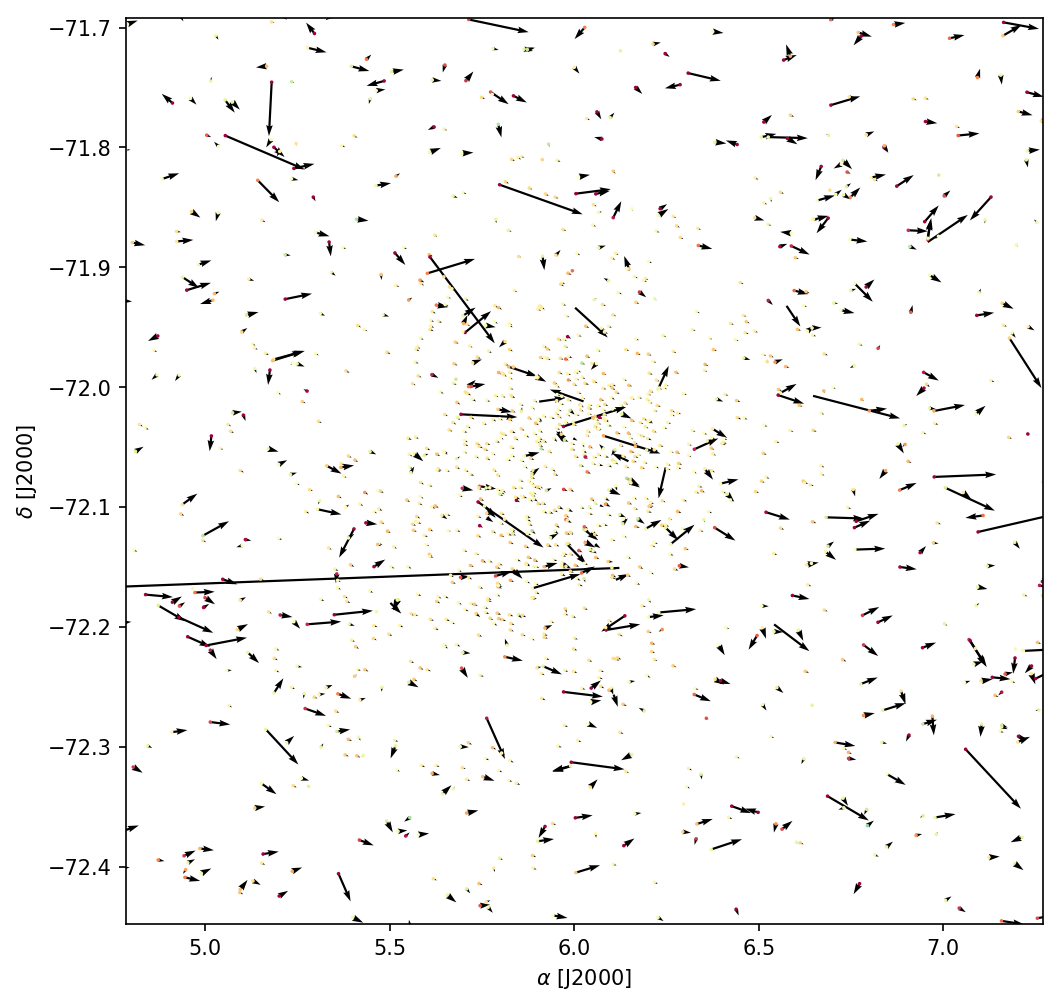

In [87]:
df_cut = df[(np.abs(df.pmra) / df.pmra_error > 10) & (np.abs(df.pmdec) / df.pmdec_error > 10) &
            ()]


fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)

q = ax.quiver(df_cut.ra, df_cut.dec, df_cut.pmra, df_cut.pmdec)
ax.scatter(df_cut.ra, df_cut.dec, c=df_cut.bp_rp, s=0.5, cmap=plt.cm.Spectral_r, vmin=0, vmax=2)

ax.set_xlabel(r'$\alpha$ [J2000]')
ax.set_ylabel(r'$\delta$ [J2000]')
ax.set_aspect(1. / np.cos(np.deg2rad(df.dec.mean())))

# zoom in using percentles...
ax.set_xlim(*np.percentile(df_cut.ra, [10, 90]))
ax.set_ylim(*np.percentile(df_cut.dec, [10, 90]))

plt.show()

#### Parallax cut

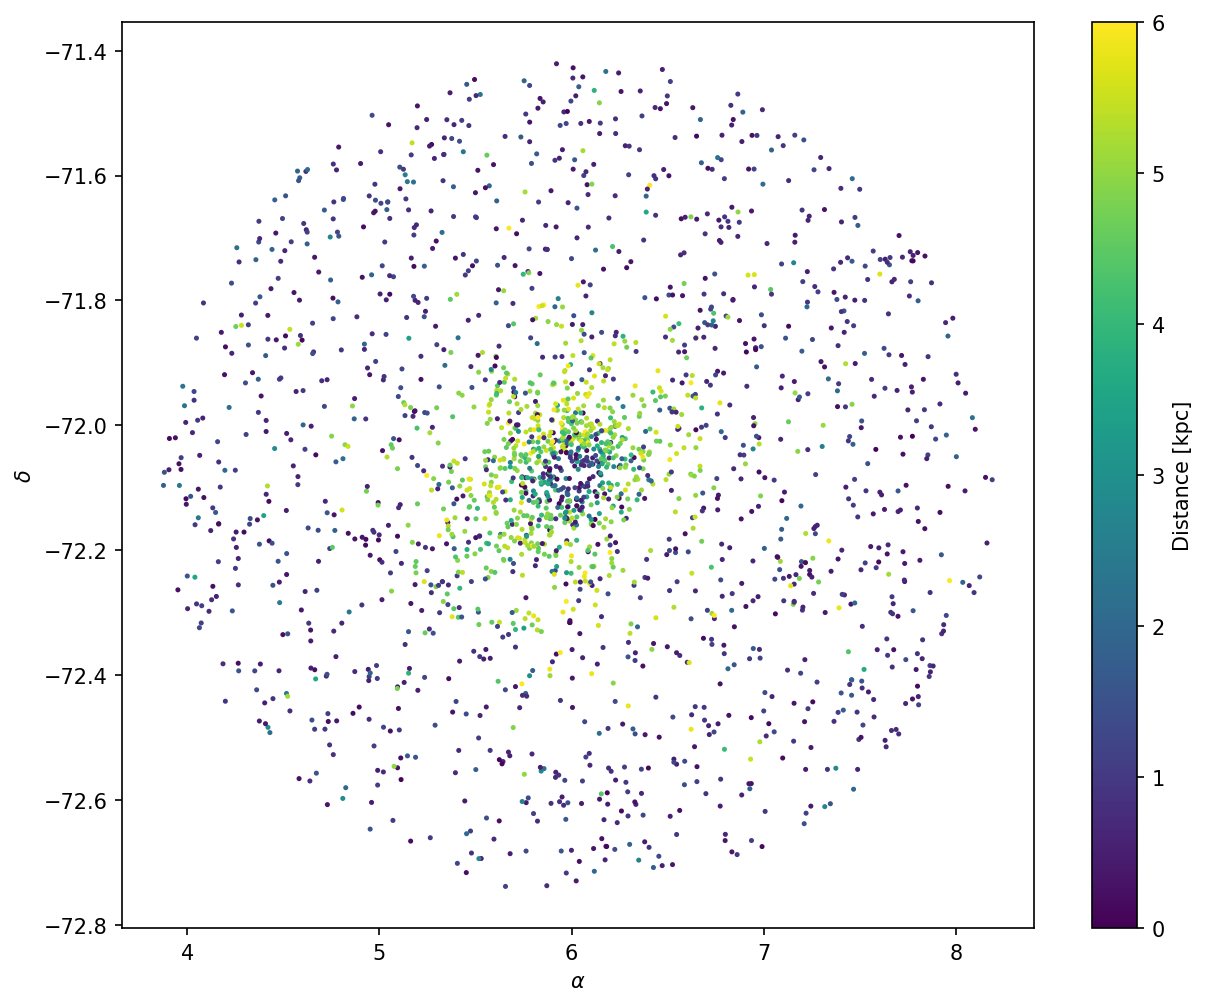

In [116]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)
im = ax.scatter(df_cut.ra, df_cut.dec, c=1 / df_cut.parallax, s=2., cmap=plt.cm.viridis, vmin=0, vmax=6)
cbar = fig.colorbar(im)
cbar.set_label('Distance [kpc]')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
ax.set_aspect(1. / np.cos(np.deg2rad(df.dec.mean())))
plt.show()

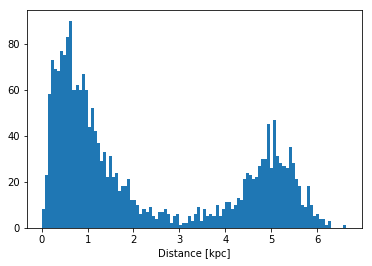

In [128]:
plt.hist(1 / df_cut.parallax, bins=100);
plt.xlabel(r'Distance [kpc]');

### Given these parallax errors in the confined space, it doesn't seem likely that we can properly undertand the dynamics